In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import style
plt.style.use('bmh')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
import matplotlib.colors as colors
import control
from collections import deque
import pickle
from Utilities.ParticleFilter import *
from Utilities.Dynamics_Constraints_Controller import *
from Utilities.cida import CIDA
import random
from scipy.linalg import sqrtm

saveFigs = True
FigWidth = 3.0
FigHeight = 1.5

In [2]:
theta = -np.pi+0.01
np.arctan2(np.sin(theta), np.cos(theta))

-3.1315926535897933

In [3]:
x0 = np.random.randn(rx,1)
x0[0] = 10
Cov0 = 0.5 * np.diag(np.ones(rx,))
num_particles = 200
Pred_Horizon_N = 5
number_of_simulations = 50
LangrangeMultp = 0.1
cida =  CIDA(x0, Cov0, num_particles, stateDynamics, measurementDynamics, Q, R,
                 Pred_Horizon_N, Controller, number_of_simulations, CostAndConstraints, LangrangeMultp)
cida.initialize(x0, Cov0)

RandomSearch method returns the desired control input, according to CIDA


In [4]:
cida.RandomSearch()

array([-0.78539816])

sampleAverage is an inherited method that returns the state conditional mean of the particle filter

In [5]:
cida.sampleAverage()

array([[10.0406091 ],
       [ 0.91651127],
       [ 0.09217523]])

In [6]:
A = np.random.rand(5,)
C = np.random.rand(5,1)
np.append(A, False)

array([0.87184938, 0.1963476 , 0.62111946, 0.13473528, 0.85697309,
       0.        ])

In [7]:
# A function to prepare the figure, its size, and plot the constraints set.

def Constraintsplot(ax):
    xc = np.linspace(-10,10,100)
    yc1 = np.sqrt(10**2-xc**2)
    yc2 = -np.sqrt(10**2-xc**2)
    ax.set_xlabel('$x\,\, (m)$', fontsize=9)
    ax.set_ylabel('$y\,\, (m)$', fontsize=9)
    ax.plot(xc,yc1,'r')
    ax.plot(xc,yc2,'r')
    ax.axis('equal')
    circle1 = plt.Circle((xs[0], ys[0]), rs[0], facecolor = 'blue')
    circle2 = plt.Circle((xs[1], ys[1]), rs[1], color='blue')
    circle3 = plt.Circle((xs[2], ys[2]), rs[2], color='blue')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    pass

0
[[8.71587371]
 [0.15997847]]
1
[[10.17171586]
 [ 0.28274229]]
2
[[11.45468333]
 [ 1.57768989]]
3
[[11.04352749]
 [ 3.04799248]]
4
[[12.85475011]
 [ 4.51990336]]


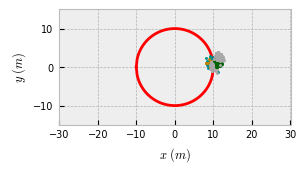

In [8]:
fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
T=5

x_true = cida.particles[:,random.sample(range(0, cida.num_particles), 1)]
AlphaAchieved_cida = np.zeros((T+1,))
ax.set_xlim((-15,15))
ax.set_ylim((-15,15))
for k in range(T):
    print(k)
    AlphaAchieved_cida[0] = cida.ViolationProb()
    uSharp = cida.RandomSearch()
    ax.plot(cida.particles[0,:],cida.particles[1,:],'o', markersize=1.1,color=list(colors.cnames)[k+22], zorder=2)
    y = measurementDynamics(x_true, uSharp) + sqrtm(R).real @ np.random.randn(ry, 1)
    print(y)
    cida.Apply_PF(uSharp, y)
    x_true = stateDynamics(x_true, uSharp, sqrtm(Q).real @ np.random.randn(rx,))

plt.savefig('L_example_SS.pdf',bbox_inches ="tight")

AlphaAchieved_cida[T]=cida.ViolationProb()   

plt.show()




In [9]:
ME = y.squeeze() - cida.g(cida.particles[:, 4], uSharp).squeeze()
-1/2 * ME @ np.linalg.inv(cida.R) @ ME

-4.183650668840669

In [10]:
#With particle filter conditional mean
Constraintsplot()
#x=[2,4,4,-2,-2,2,2]
#y=[4,4,-6,-6,-4,-4,4]
#plt.plot(x,y)
plt.plot(0,0,'.')
AlphaAchievedCM=np.full((1,T+1), np.nan)
plt.axis('equal')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$z_k$', fontsize=9)  
plt.ylabel('$h_k$', fontsize=9) 
#plt.xlabel('$z_k^{\prime\prime}$')  
#plt.ylabel('$h_k^{\prime\prime}$') 
Xi=Xi0
x_true=np.full((2,T+1), np.nan)
x_true[:,0]=(mu_x0+np.sqrt(var_x0)@np.random.randn(2, 1)).reshape(2,)
for k in range(T):
    AlphaAchievedCM[0,k]=AchievedAlpha(Xi)
    x0mean=np.sum(Xi, axis=1)/L
    plt.plot(Xi[0,:],Xi[1,:],'o', markersize=1.1,color=list(colors.cnames)[k+22],zorder=2)
    plt.plot(x0mean[0],x0mean[1],marker='s',ms=4, color = 'black' ,mfc=list(colors.cnames)[k+22], zorder=3)
    u=controller(x0mean)
    Xiplus, gx=TimeUpdate(Xi,var_w,var_v,u)
    y=x_true[0,k]+np.sqrt(var_v)[0,0]*np.random.randn()
    disturbance_k=np.sqrt(var_w)@np.random.randn(2, 1)
    x_true[:,k+1]=(dynamics(x_true[:,k],u,disturbance_k)).reshape(2,)
    Likelihoods=Measurement_Likelihood(np.array([gx]),y,var_v[0,0])
    Xi=Resampler(Xiplus,Likelihoods)

AlphaAchievedCM[0,T]=AchievedAlpha(Xi)          
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.rc('axes', labelsize=7) #fontsize of the x and y labels
plt.savefig('L_example_CM.pdf',bbox_inches ="tight")
plt.show()



TypeError: Constraintsplot() missing 1 required positional argument: 'ax'

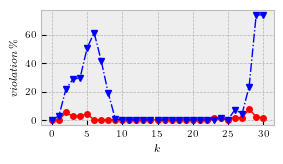

In [ ]:
# Generating the violation rates figure
plt.style.use('bmh')
plt.figure(figsize=(3.0,1.5))
plt.plot(AlphaAchieved[0,:]*100,'-or', linewidth=1, ms=4)
plt.plot(AlphaAchievedCM[0,:]*100,'-.vb', linewidth=1, ms=4)
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels

plt.xlabel('$k$', fontsize=8)  
plt.ylabel('$violation\,\%$', fontsize=8) 
plt.savefig('AchievedAlpha_StabilizingK.pdf',bbox_inches ="tight")

plt.show()